In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sberbank-russian-housing-market/train.csv.zip
/kaggle/input/sberbank-russian-housing-market/test.csv.zip
/kaggle/input/sberbank-russian-housing-market/macro.csv.zip
/kaggle/input/sberbank-russian-housing-market/sample_submission.csv.zip
/kaggle/input/sberbank-russian-housing-market/data_dictionary.txt


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import preprocessing,metrics
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
import zipfile

In [4]:
with zipfile.ZipFile('../input/sberbank-russian-housing-market/train.csv.zip','r') as z:
    z.extractall('.')
with zipfile.ZipFile('../input/sberbank-russian-housing-market/test.csv.zip','r') as z:
    z.extractall('.')
with zipfile.ZipFile('../input/sberbank-russian-housing-market/macro.csv.zip','r') as z:
    z.extractall('.')

In [5]:
pd.set_option('display.max_columns', 500)
train=pd.read_csv('../working/train.csv')
test=pd.read_csv('../working/test.csv')
macro=pd.read_csv('../working/macro.csv')

In [6]:
train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

In [7]:
test.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118]),
 <a list of 119 Text major ticklabel objects>)

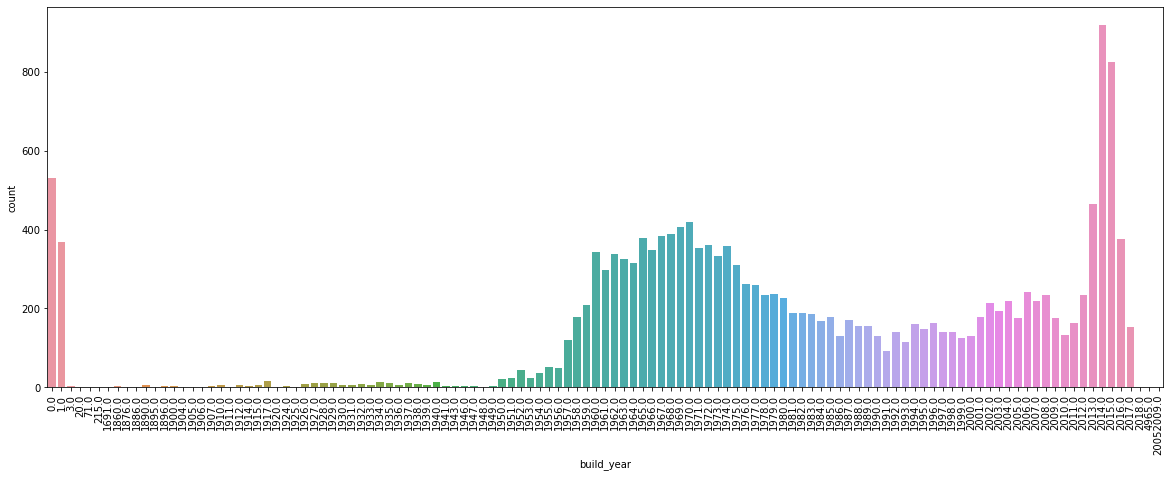

In [8]:
plt.figure(figsize=(20,7))
sns.countplot(train['build_year'])
plt.xticks(rotation=90)

In [9]:
train.loc[train['id']==10092,'build_year']=2009
train.loc[train['id']==15223,'build_year']=1965


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106]),
 <a list of 107 Text major ticklabel objects>)

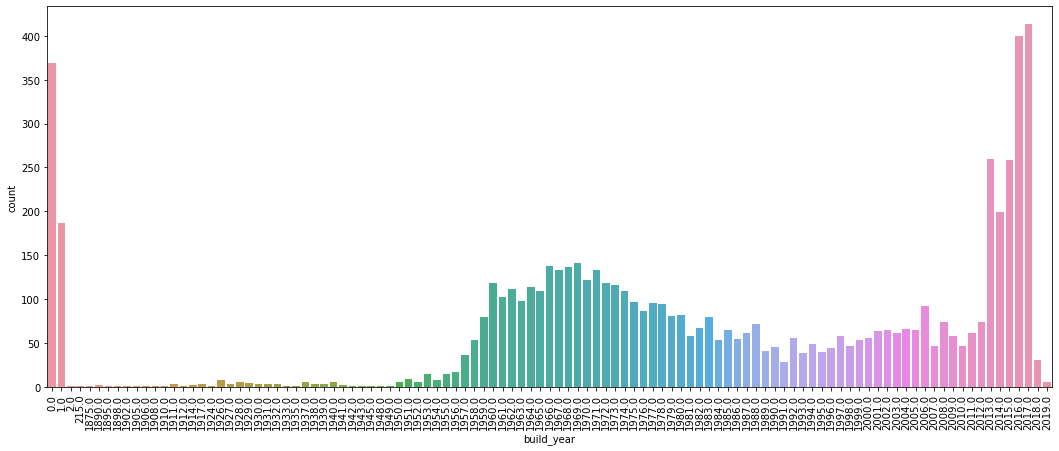

In [10]:
plt.figure(figsize=(18,7))
sns.countplot(test['build_year'])
plt.xticks(rotation=90)

In [11]:
data=train.copy()
for i in data.columns:
    if(data[i].dtype=='object'):
        lbe=preprocessing.LabelEncoder()
        lbe.fit(data[i].values)
        data[i]=lbe.transform(data[i].values)

In [12]:
price=data['price_doc']
data=data.drop(['id','price_doc','timestamp'],axis=1)

In [13]:
dtrain=xgb.DMatrix(data,price,feature_names=data.columns.values)
params = {
    'eta' : 0.5 ,'max_depth':8 , 'subsample' :0.8,'colsample_bytree' : 0.8 ,'objective' : 'reg:squarederror',
    'eval_metric':'rmse'
}
model=xgb.train(params,dtrain,num_boost_round=200,evals=[(dtrain,"Train")],early_stopping_rounds=20)

[0]	Train-rmse:4891899.00000
Will train until Train-rmse hasn't improved in 20 rounds.
[1]	Train-rmse:3250474.50000
[2]	Train-rmse:2532872.75000
[3]	Train-rmse:2253687.00000
[4]	Train-rmse:2133343.75000
[5]	Train-rmse:2046146.62500
[6]	Train-rmse:1973966.37500
[7]	Train-rmse:1931920.25000
[8]	Train-rmse:1896922.62500
[9]	Train-rmse:1873263.62500
[10]	Train-rmse:1834285.37500
[11]	Train-rmse:1808217.12500
[12]	Train-rmse:1794702.25000
[13]	Train-rmse:1767575.37500
[14]	Train-rmse:1737500.75000
[15]	Train-rmse:1704774.25000
[16]	Train-rmse:1682480.12500
[17]	Train-rmse:1663932.37500
[18]	Train-rmse:1633086.87500
[19]	Train-rmse:1619043.87500
[20]	Train-rmse:1601893.00000
[21]	Train-rmse:1595716.00000
[22]	Train-rmse:1582858.37500
[23]	Train-rmse:1568831.12500
[24]	Train-rmse:1559977.00000
[25]	Train-rmse:1545386.87500
[26]	Train-rmse:1528091.25000
[27]	Train-rmse:1509000.37500
[28]	Train-rmse:1497018.25000
[29]	Train-rmse:1487365.00000
[30]	Train-rmse:1478878.75000
[31]	Train-rmse:146670

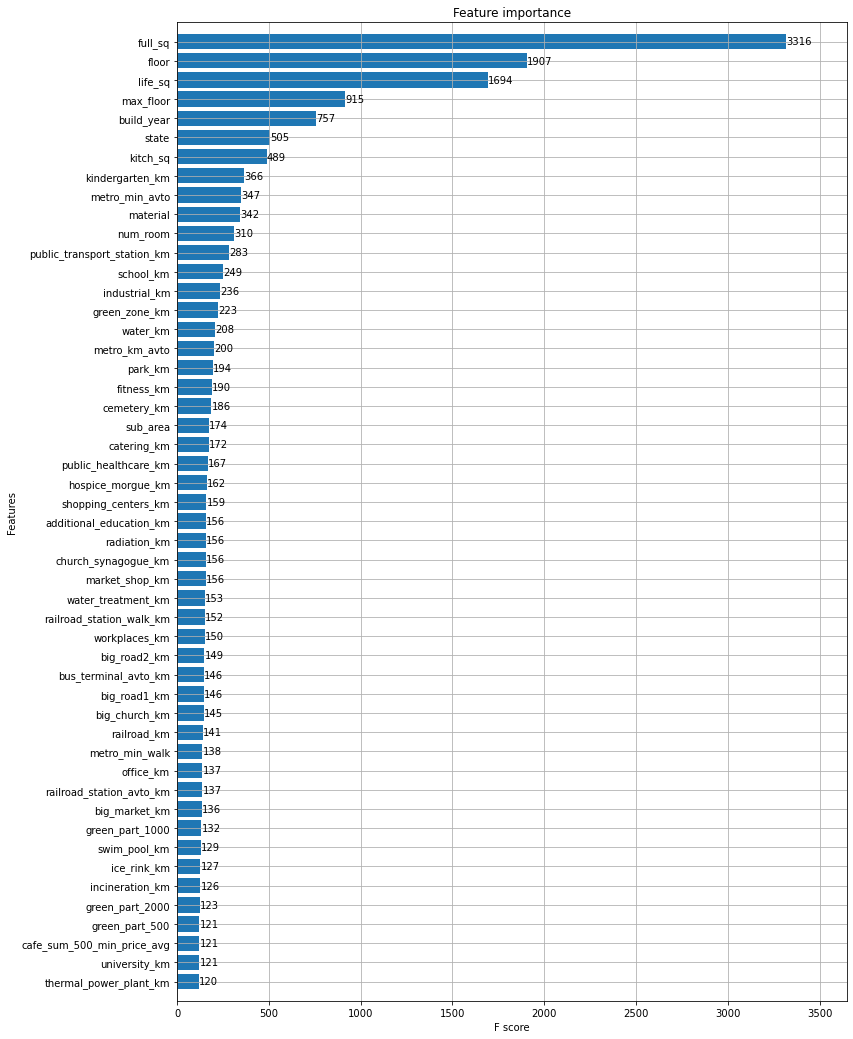

In [14]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [15]:
train['full_sq'].describe()

count    30471.000000
mean        54.214269
std         38.031487
min          0.000000
25%         38.000000
50%         49.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

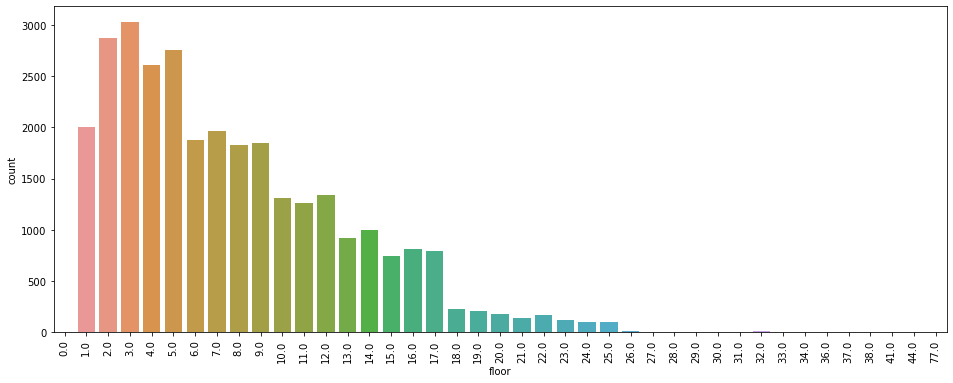

In [16]:
ax=plt.figure(figsize=(16,6))
sns.countplot(train['floor'])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

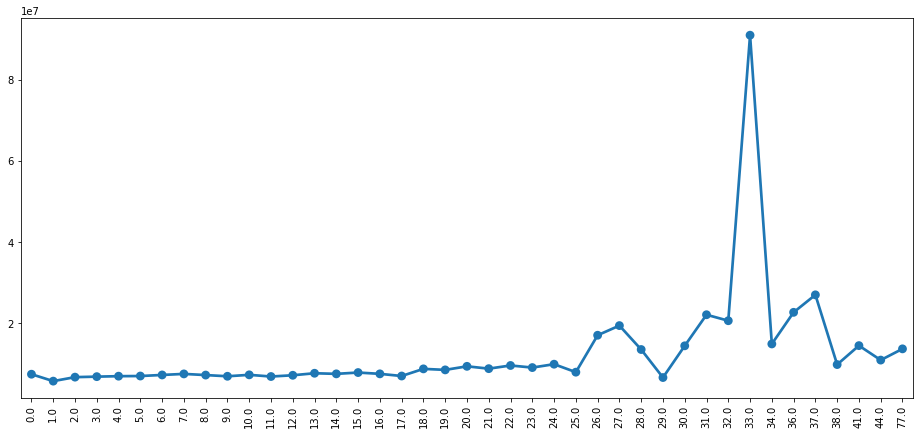

In [17]:
plt.figure(figsize=(16,7))
group=train.groupby('floor')['price_doc'].aggregate(np.mean).reset_index()
sns.pointplot(group['floor'].values,group['price_doc'].values)
plt.xticks(rotation=90)

In [18]:
train[train['floor']==3]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [19]:
train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

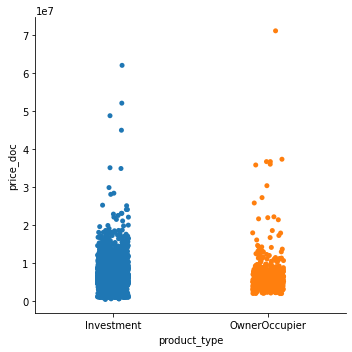

In [20]:
x=train[train['floor']==4]

sns.catplot(x='product_type',y='price_doc',data=x)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]),
 <a list of 117 Text major ticklabel objects>)

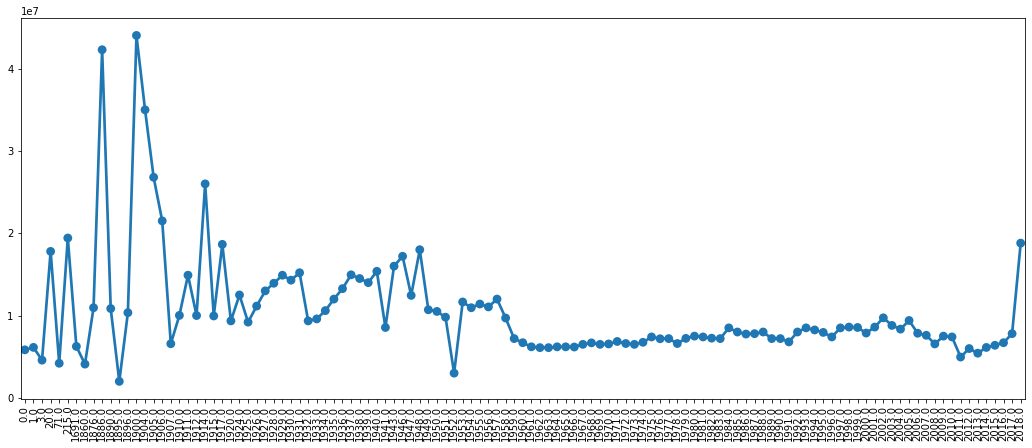

In [21]:
plt.figure(figsize=(18,7))
x=train.groupby('build_year')['price_doc'].aggregate(np.median).reset_index()
sns.pointplot(x['build_year'].values,x['price_doc'].values)
plt.xticks(rotation=90)

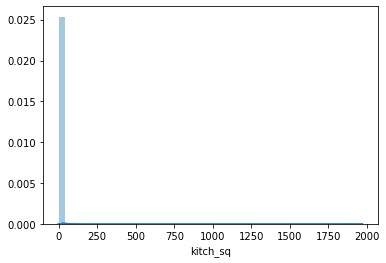

In [22]:
sns.distplot(test['kitch_sq'],kde=True)

In [23]:
train[train['kitch_sq']>500]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [24]:
train['sub_area']

0                    Bibirevo
1           Nagatinskij Zaton
2              Tekstil'shhiki
3                      Mitino
4                   Basmannoe
                 ...         
30466                Otradnoe
30467                Tverskoe
30468    Poselenie Vnukovskoe
30469            Obruchevskoe
30470             Novogireevo
Name: sub_area, Length: 30471, dtype: object

<Figure size 1440x1440 with 0 Axes>

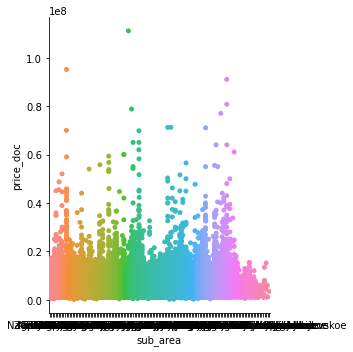

In [25]:
plt.figure(figsize=(20,20))
sns.catplot(x='sub_area',y='price_doc',data=train)


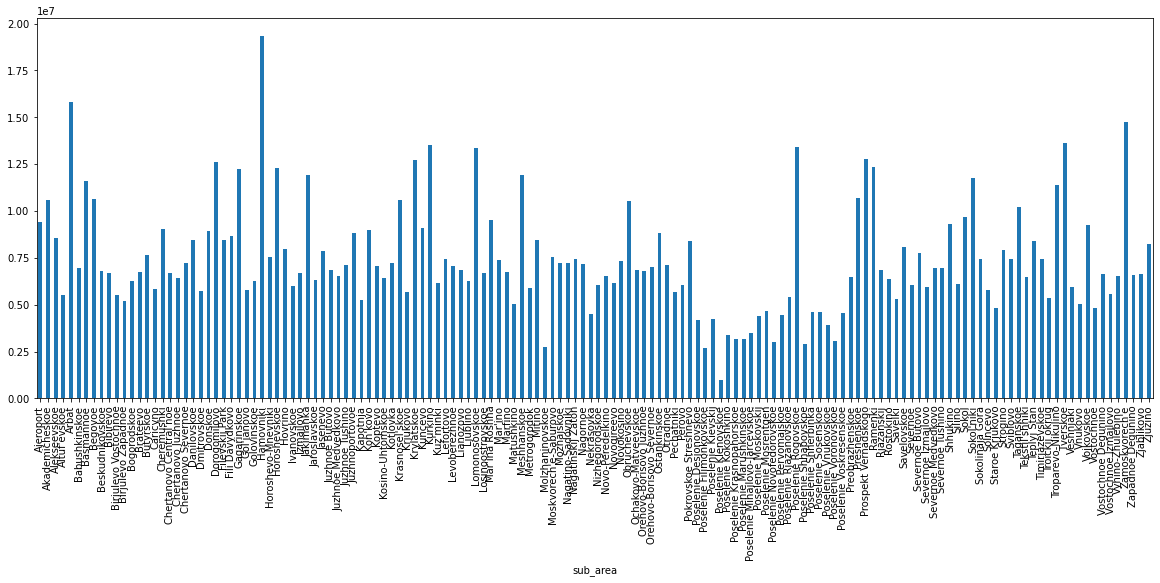

In [44]:
x=train[train['product_type']=='Investment']
df=x.groupby('sub_area')['price_doc'].aggregate(np.mean)
plt.figure(figsize=(20,7))
df.plot(kind='bar')

In [52]:
train.loc[train['state']==33,'state']=3

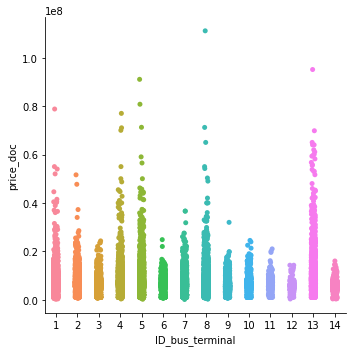

In [63]:
sns.catplot('ID_bus_terminal','price_doc',data=train)

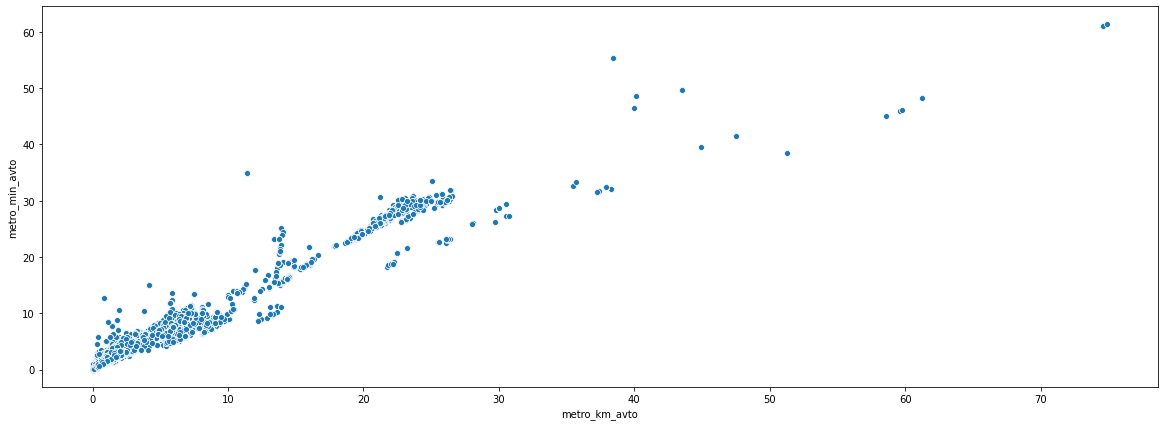

In [67]:
plt.figure(figsize=(20,7))
sns.scatterplot(train['metro_km_avto'],train['metro_min_avto'])

In [84]:
train['sqperRoom']=np.where(train['num_room'].isna()|train['life_sq'].isna(),None,train['life_sq']/train['num_room'])

In [86]:
test['sqperRoom']=np.where(test['num_room'].isna()|test['life_sq'].isna(),None,test['life_sq']/test['num_room'])

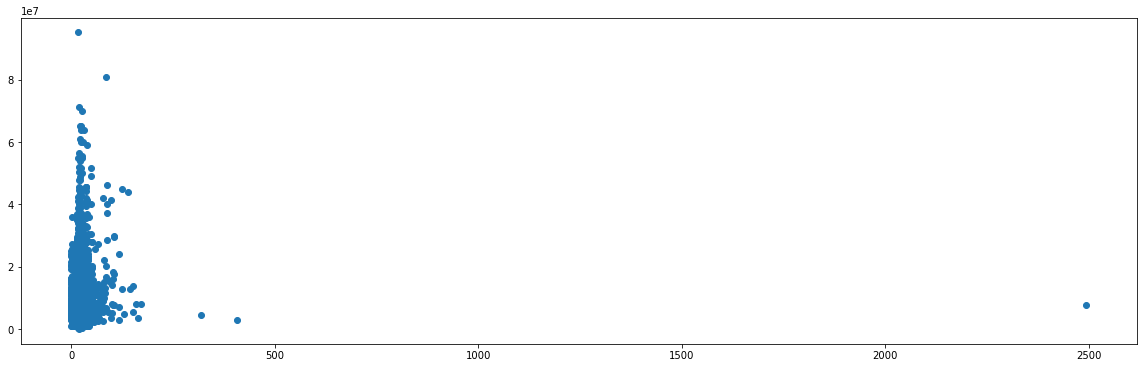

In [89]:
plt.figure(figsize=(20,6))
plt.scatter(train['sqperRoom'],train['price_doc'])

In [90]:
train[train['sqperRoom']>1600]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

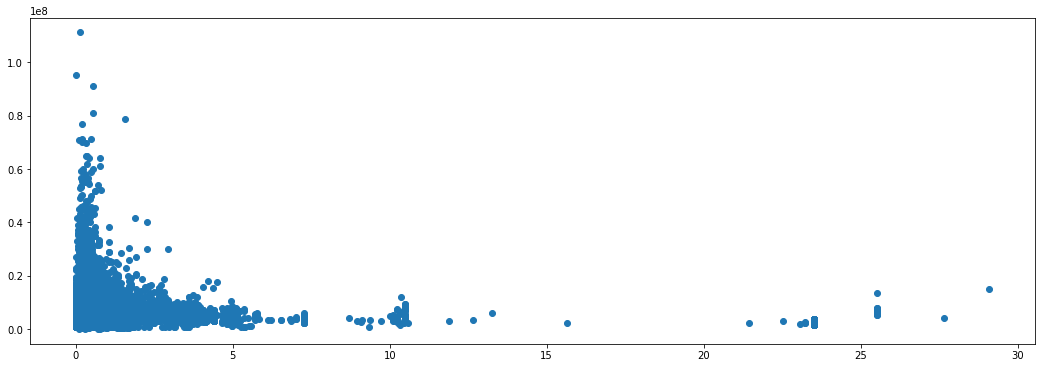

In [93]:
plt.figure(figsize=(18,6))
plt.scatter(train['kindergarten_km'],train['price_doc'])

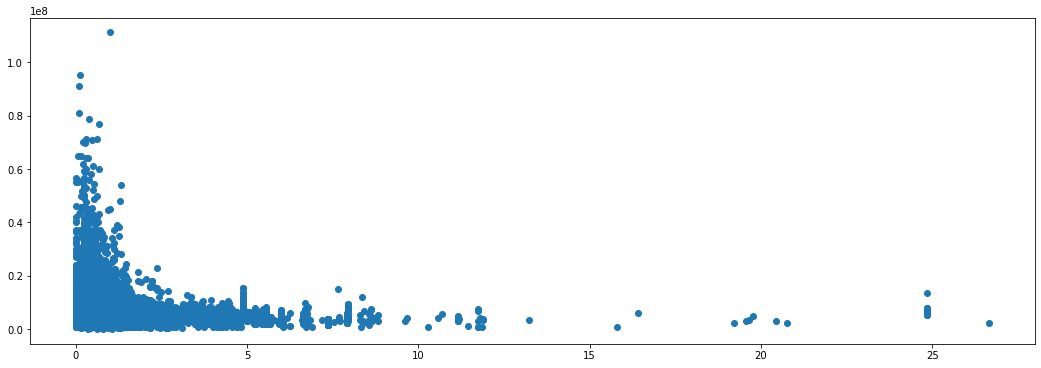

In [109]:
plt.figure(figsize=(18,6))
plt.scatter(train['fitness_km'],train['price_doc'])

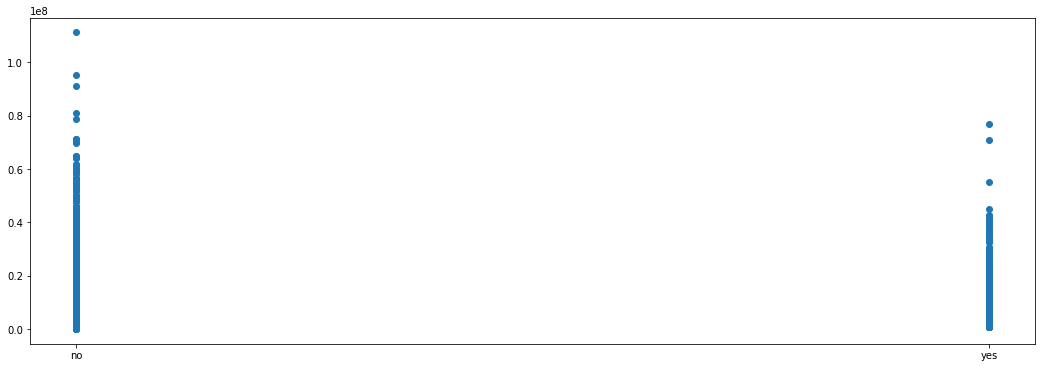

In [114]:
plt.figure(figsize=(18,6))
plt.scatter(train['railroad_terminal_raion'],train['price_doc'])

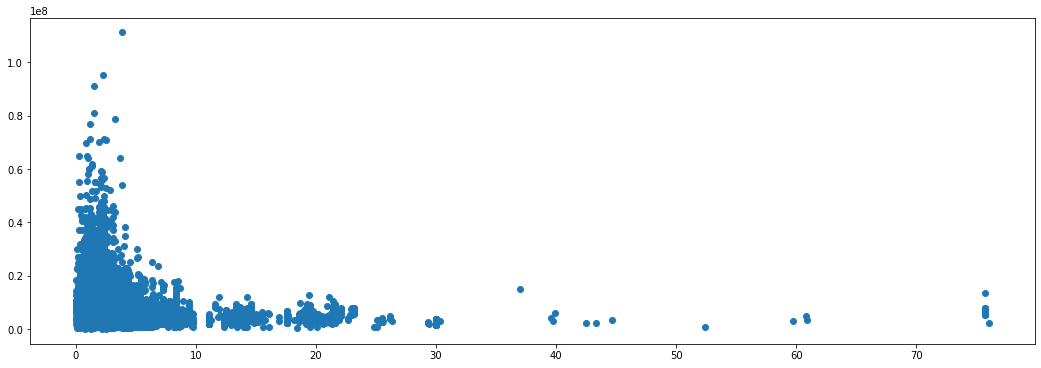

In [103]:
plt.figure(figsize=(18,6))
plt.scatter(train['public_healthcare_km'],train['price_doc'])

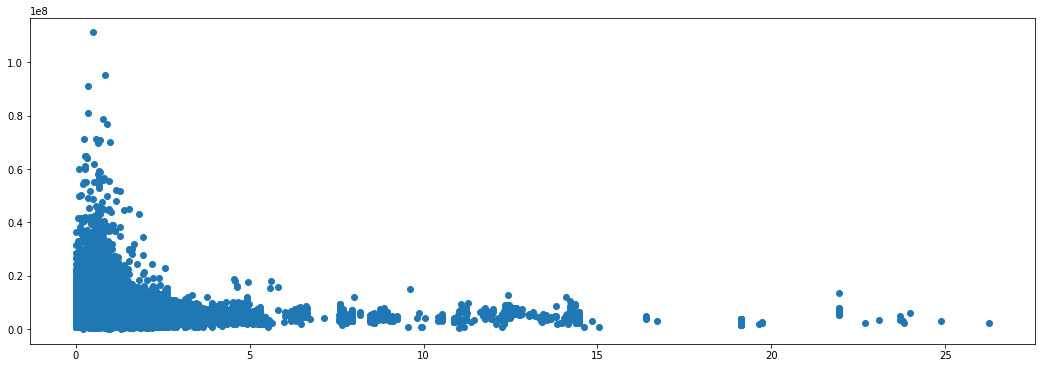

In [104]:
plt.figure(figsize=(18,6))
plt.scatter(train['shopping_centers_km'],train['price_doc'])

In [115]:
train['basic_km']=train['public_healthcare_km']+train['public_transport_station_km']+train['shopping_centers_km']

In [117]:
from sklearn.feature_selection import VarianceThreshold
data
sel=VarianceThreshold(threshold=0)
sel.fit(data)

ValueError: setting an array element with a sequence.